In [1]:

import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa

import tensorflow as tf
import tensorflow_hub as hub
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.losses import BinaryCrossentropy
#import tensorflow_io as tfio

2025-04-24 02:52:32.411550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745463152.612936      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745463152.672354      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load Yamnet model

In [2]:

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)



I0000 00:00:1745463176.096945      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## Data Preprocessing

In [19]:

def data_balance(path_to_subset):

    for folder in (os.listdir(path_to_subset)):
        #ingone .txt file 
        if folder.split(".")[-1]=="txt":
            pass
        else:
            print("class name :",folder)
            print(len(os.listdir(os.path.join(path_to_subset, folder))))
              
         
        
data_balance("/kaggle/input/audio-sentiment-analysis/Audio_Dataset")

class name : happy_emotion
1923
class name : anger_emotion
1923
class name : fear_emotion
1923
class name : sad_emotion
1923
class name : disgust_emotion
1923
class name : neutral_emotion
1703


In [61]:
def extract_embedding(wav_data, label):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
    
  # Repeat the label to match the number of embeddings
  repeated_labels = tf.tile(tf.expand_dims(label, axis=0), [num_embeddings, 1])


  #label = tf.cast(label, tf.int64)  # Optional: ensure proper dtype
  #repeated_labels = tf.repeat(label, repeats=num_embeddings)

    
  return (embeddings,repeated_labels)
  #return (embeddings[0],label)


def data_prepocessing(path_to_subset):

    data = []
    folder_name = []
    
    embedings_array=[]
    label_array=[]
    
    
    for folder in tqdm(os.listdir(path_to_subset)):
        
        if folder.split(".")[-1]=="txt":
            pass
            
        else:
    
          for audio in os.listdir(os.path.join(path_to_subset, folder)):
              path_to_audio = os.path.join(path_to_subset, folder,audio)
        
              sound_sample,sr=librosa.load(path_to_audio ,sr=16000)
              #dur = librosa.get_duration(y=sound_sample, sr=sr)
              #print(dur)
    
              
              wav_data_tensor = tf.convert_to_tensor(sound_sample, dtype=tf.float32)
              
              
              data.append(wav_data_tensor)
              folder_name.append(folder.split("_")[0])
    
    #print(folder_name.count("fake"))
    #print(folder_name.count("real"))
    # Create the LabelEncoder
    lb = LabelBinarizer()
    
    # Fit and transform the labels
    binary_labels = lb.fit_transform(folder_name)
    #y_one_hot = np.hstack((1 - binary_labels, binary_labels))

    #label = tf.convert_to_tensor(y_one_hot, dtype=tf.int32)

    # Initialize LabelEncoder
    #label_encoder = LabelEncoder()
    
    # Fit and transform data
    #encoded_labels = label_encoder.fit_transform(folder_name)

    #label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(binary_labels.classes_)))
    #print("Label Mapping:", label_mapping)


    
    for sound_data,label2 in tqdm(zip(data, binary_labels)):
        embeddings,repeated_labels=extract_embedding(sound_data, label2)
        embedings_array.extend(embeddings)
        label_array.extend(repeated_labels)

    #label = tf.convert_to_tensor(y_one_hot, dtype=tf.int32)
    print("\nClasses:", lb.classes_)
    return embedings_array,label_array,lb.classes_



In [62]:

path_to_subset= '/kaggle/input/audio-sentiment-analysis/Audio_Dataset'
data,label,classes=data_prepocessing(path_to_subset)

100%|██████████| 6/6 [00:35<00:00,  5.90s/it]
11318it [01:16, 148.49it/s]


Classes: ['anger' 'disgust' 'fear' 'happy' 'neutral' 'sad']


In [63]:

print("Dataset len :",len(data))
print("Dataset labels len :",len(label))

Dataset len : 55456
Dataset labels len : 55456


In [64]:

print(data[100])
print(label[100])

tf.Tensor([0.         0.21909757 0.02091259 ... 0.01552224 0.         0.        ], shape=(1024,), dtype=float32)
tf.Tensor([0 0 0 1 0 0], shape=(6,), dtype=int64)


## Split the data

In [65]:

# Split into training and validation sets
from sklearn.model_selection import train_test_split
# Convert TensorFlow dataset to NumPy arrays (or lists)
features = []
labels = []

for feature, label in tqdm(zip(data,label)):
    features.append(feature.numpy())
    labels.append(label.numpy())

features = np.array(features)
labels = np.array(labels)


55456it [00:04, 13755.28it/s]


In [66]:

# Split into training and test sets
X_train, X_test, Y_train, y_test = train_test_split(features, labels, test_size=0.025, random_state=42)
x_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Convert back to TensorFlow datasets if needed
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

print("len train_ds :",len(train_ds))
print("len test_ds :",len(test_ds))
print("len val_ds :",len(val_ds))

# Optionally, batch the datasets
train_ds = train_ds.cache().shuffle(500).batch(64).prefetch(tf.data.AUTOTUNE)
#test_ds = test_ds.batch(128).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)

# Print the datasets to confirm
for data, label in train_ds.take(1):
    print("Train data:", data.shape)
    print("Train label:", label.shape)

#for data, label in test_ds.take(1):
 #   print("Test data:", data.shape)
 #   print("Test label:", label.shape)

for data, label in val_ds.take(1):
    print("val data:", data.shape)
    print("val label:", label.shape)

len train_ds : 54069
len test_ds : 1387
len val_ds : 10814
Train data: (64, 1024)
Train label: (64, 6)
val data: (64, 1024)
val label: (64, 6)


In [67]:
for path, label in train_ds.take(1):
    print("path:", path)
    print("Label:", label)

path: tf.Tensor(
[[0.         0.11729325 0.14272772 ... 0.         0.         0.        ]
 [0.         0.40563425 0.23666441 ... 0.         0.         0.        ]
 [0.         0.07757445 0.6584234  ... 0.47761902 0.05108609 0.        ]
 ...
 [0.39557752 0.13427168 0.3010768  ... 0.31589118 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.25767824 0.99611044 0.01798967 ... 0.         0.         0.        ]], shape=(64, 1024), dtype=float32)
Label: tf.Tensor(
[[0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]
 [0 0 1 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 1 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 1 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 1 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 1]
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]
 [0 0 1 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0

## Create model

In [68]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, RepeatVector, BatchNormalization, TimeDistributed, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy

### ANN

In [73]:

ann_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
], name='ann_model')


ann_model.summary()

Model: "ann_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 6)                   │           6,150 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 925,446 (3.53 MB)

 Trainable params: 925,446 (3.53 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:

#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
loss = tf.keras.losses.CategoricalCrossentropy()



ann_model.compile(loss=loss,
              optimizer="adam",
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=20,
                                            restore_best_weights=True,
                                           verbose=1)


# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint("ann_model.keras", save_best_only=True, monitor='val_loss', verbose=1)

In [75]:

ann_history=ann_model.fit(train_ds,
                       epochs=100,
                       validation_data=val_ds,
                       callbacks=[checkpoint],
                         verbose=1)

Epoch 1/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3429 - loss: 1.5686
Epoch 1: val_loss improved from inf to 1.42228, saving model to ann_model.keras
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3430 - loss: 1.5685 - val_accuracy: 0.4105 - val_loss: 1.4223
Epoch 2/100
821/845 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4257 - loss: 1.3992
Epoch 2: val_loss improved from 1.42228 to 1.36103, saving model to ann_model.keras
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4258 - loss: 1.3989 - val_accuracy: 0.4429 - val_loss: 1.3610
Epoch 3/100
820/845 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4493 - loss: 1.3462
Epoch 3: val_loss improved from 1.36103 to 1.31450, saving model to ann_model.keras
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4493 - loss: 1.3461 - val_accuracy: 0.4600 - val_loss: 1.3145
Epoch 4/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4656 - loss: 1.3071
Epoch 4: val_loss improved from 1.31450 to 1.29410, s

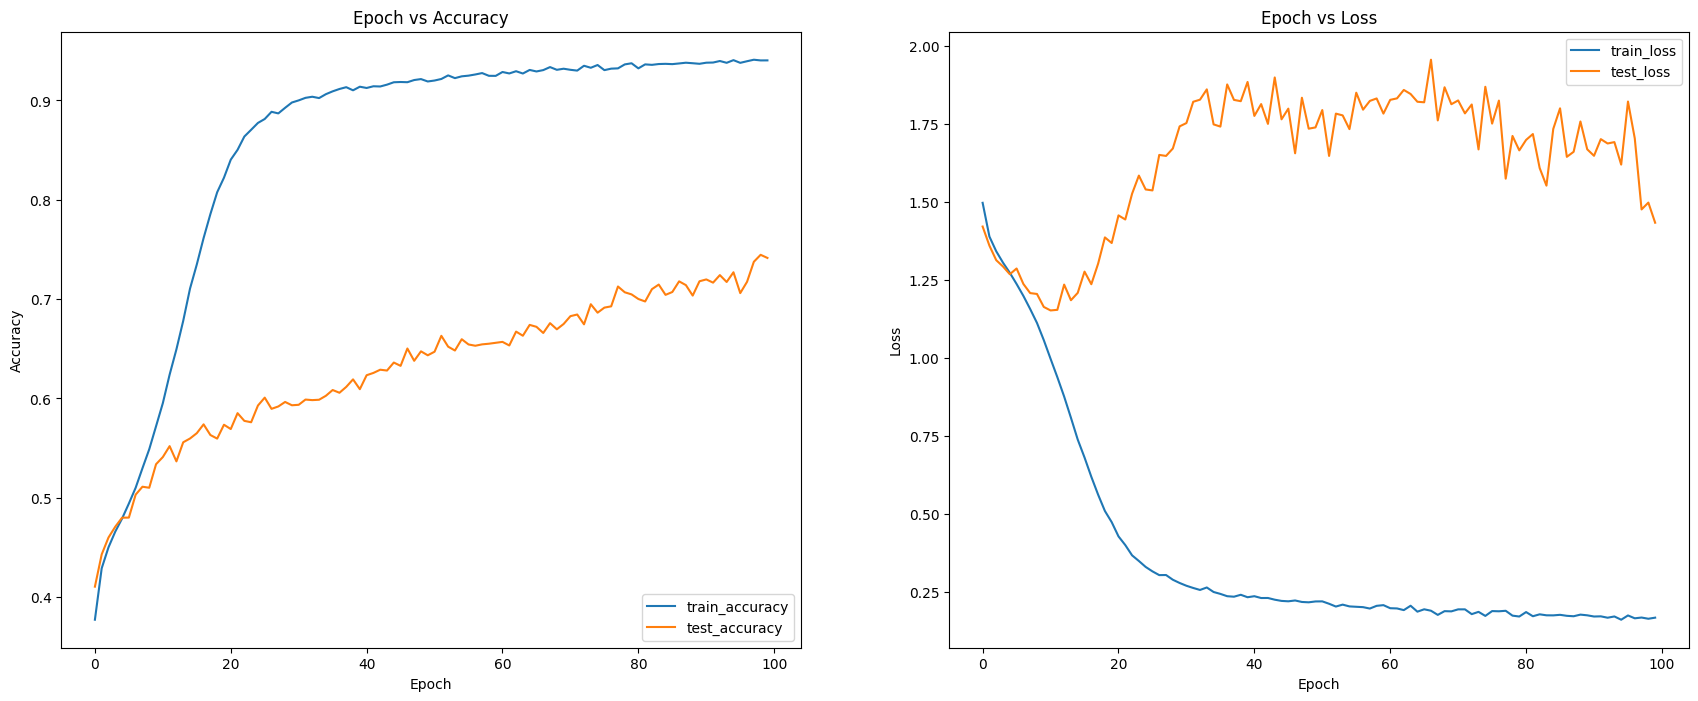

In [76]:
##
plt.figure(figsize=(21, 8))
plt.subplot(1, 2, 1)
plt.plot(ann_history.history['accuracy'], label='train_accuracy')
plt.plot(ann_history.history['val_accuracy'], label='test_accuracy')
plt.title("Epoch vs Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(ann_history.history["loss"], label='train_loss')
plt.plot(ann_history.history["val_loss"], label='test_loss')
plt.title("Epoch vs Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

### CNN1D

In [81]:

def cnn_model():
    model = Sequential()
    
    # First Bidirectional LSTM layer with return_sequences=True to maintain 3D output
    model.add(Conv1D(filters=32, kernel_size=3,padding='same',strides=1, activation='relu', input_shape=(1024, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    #model.add(Conv1D(filters=64, kernel_size=3,strides=1, activation='relu'))
    #model.add(Conv1D(filters=128, kernel_size=3,strides=1, activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    
    #model.add(Conv1D(filters=256, kernel_size=3,strides=1, activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(Dropout(0.2))
    
    model.add(Flatten())
    #model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(6, activation='softmax'))
    
    model.summary()

    return model

cnn_model=cnn_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 1024, 32)            │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 512, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,394,502 (32.02 MB)

 Trainable params: 8,393,414 (32.02 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [82]:
#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),


loss = tf.keras.losses.CategoricalCrossentropy()

cnn_model.compile(loss=loss,
              optimizer="adam",
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=20,
                                            restore_best_weights=True,
                                            verbose=1)

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint("cnn_model.keras", save_best_only=True, monitor='val_loss', verbose=1)

In [85]:

cnn_history=cnn_model.fit(train_ds,
                       epochs=200,
                       validation_data=val_ds,
                       callbacks=[checkpoint],
                          verbose=1)

Epoch 1/200
841/845 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6071 - loss: 0.9854
Epoch 1: val_loss did not improve from 0.75441
845/845 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6071 - loss: 0.9854 - val_accuracy: 0.7466 - val_loss: 0.7591
Epoch 2/200
841/845 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6091 - loss: 0.9858
Epoch 2: val_loss did not improve from 0.75441
845/845 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6090 - loss: 0.9858 - val_accuracy: 0.7278 - val_loss: 0.7560
Epoch 3/200
841/845 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6114 - loss: 0.9846
Epoch 3: val_loss improved from 0.75441 to 0.74231, saving model to cnn_model.keras
845/845 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6114 - loss: 0.9846 - val_accuracy: 0.7624 - val_loss: 0.7423
Epoch 4/200
841/845 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6085 - loss: 0.9802
Epoch 4: val_loss improved from 0.74231 to 0.73212, saving model to cnn_model.keras
845/845 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/ste

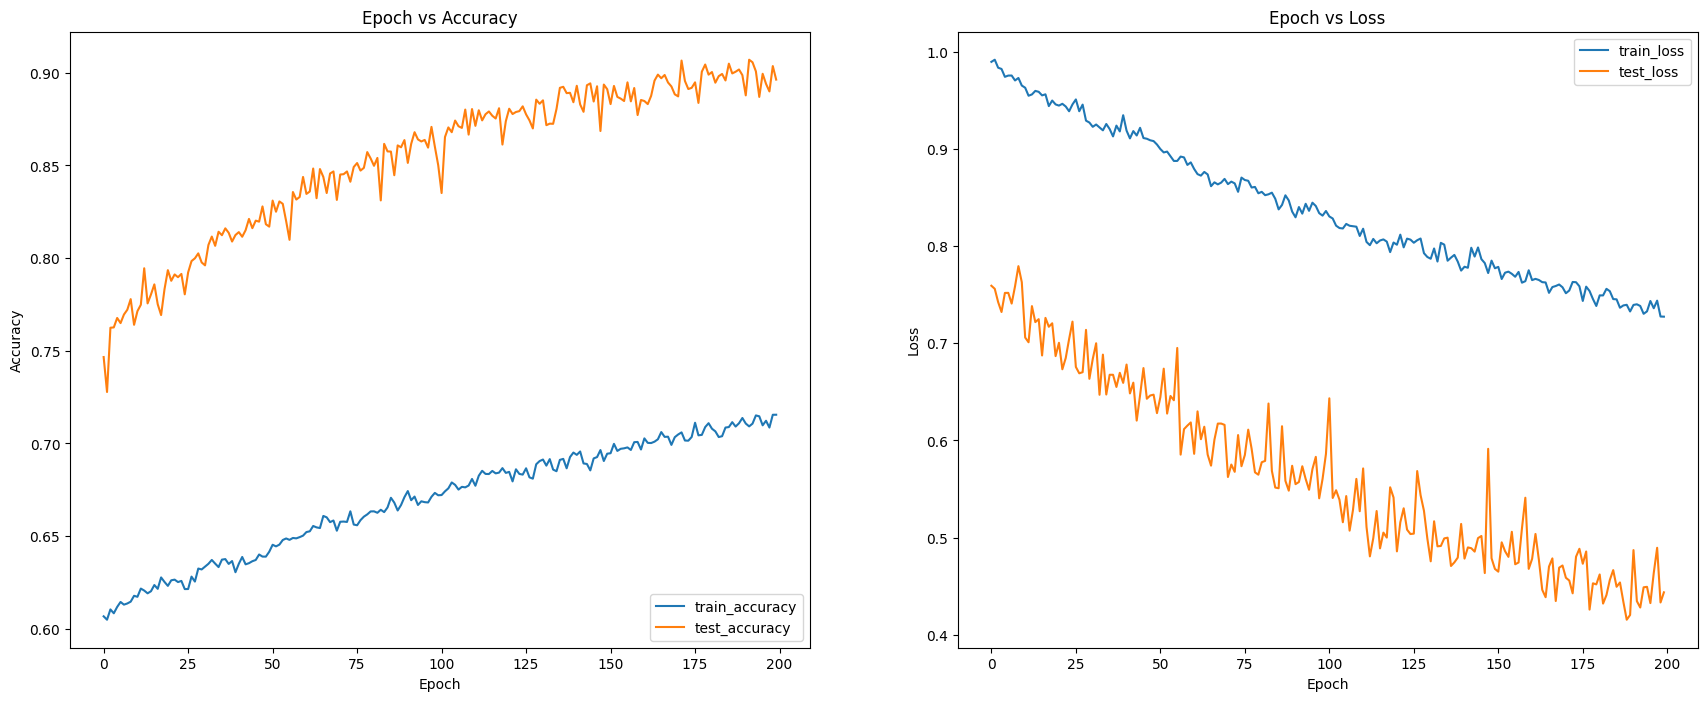

In [86]:

plt.figure(figsize=(21, 8))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='train_accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='test_accuracy')
plt.title("Epoch vs Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(cnn_history.history["loss"], label='train_loss')
plt.plot(cnn_history.history["val_loss"], label='test_loss')
plt.title("Epoch vs Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

## Save Model

### ANN

In [77]:
class YamnetLayer(tf.keras.layers.Layer):
    def __init__(self, yamnet_model_handle, **kwargs):
        super(YamnetLayer, self).__init__(**kwargs)
        self.yamnet_layer = hub.KerasLayer(yamnet_model_handle, trainable=False)

    def call(self, inputs):
        return self.yamnet_layer(inputs)

class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)


embedding_extraction_layer = YamnetLayer(yamnet_model_handle, name='yamnet',trainable=False)
input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = ann_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
saved_model_path = './ann_voice_emotion'
serving_model.export(saved_model_path)

Saved artifact at './ann_voice_emotion'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None,), dtype=tf.float32, name='audio')
Output Type:
  TensorSpec(shape=(6,), dtype=tf.float32, name=None)
Captures:
  140564387132624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140564387121104: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  140564387133776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140564387124560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140564387123600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140564387135312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140564387124368: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  140564387134928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140564387131856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140564387121872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140564387133200: TensorSpec(sha

### cnn

In [88]:


class YamnetLayer(tf.keras.layers.Layer):
    def __init__(self, yamnet_model_handle, **kwargs):
        super(YamnetLayer, self).__init__(**kwargs)
        self.yamnet_layer = hub.KerasLayer(yamnet_model_handle, trainable=False)

    def call(self, inputs):
        return self.yamnet_layer(inputs)

class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)


# Define the custom layer
class ExpandDimsLayer(tf.keras.layers.Layer):
    def __init__(self, axis=-1, **kwargs):  # Default to adding the dimension at the last axis
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)


# Instantiate layers
embedding_extraction_layer = YamnetLayer(yamnet_model_handle, name='yamnet', trainable=False)
expand_dims_layer = ExpandDimsLayer(axis=-1, name='expand_dims')  # Add dimension at the last axis
reduce_mean_layer = ReduceMeanLayer(axis=0, name='classifier')

# Define the model
input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')

# Pass input through layers
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
embeddings_output_expanded = expand_dims_layer(embeddings_output)  # Shape: (batch_size, 1024, 1)
serving_outputs = cnn_model(embeddings_output_expanded)
serving_outputs = reduce_mean_layer(serving_outputs)

# Build and save the final serving model
serving_model = tf.keras.Model(input_segment, serving_outputs)
saved_model_path = './cnn_voice_emotion'
serving_model.export(saved_model_path)


Saved artifact at './cnn_voice_emotion'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None,), dtype=tf.float32, name='audio')
Output Type:
  TensorSpec(shape=(6,), dtype=tf.float32, name=None)
Captures:
  140564398675088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140564398673168: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  140564398683728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140564398685072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140564398675472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140564398679696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140564398680656: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  140564398672400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140564398671632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140564398681040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140564398679888: TensorSpec(sha

## Evaluation

In [78]:
#
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def evaluation(model,test_ds,classes):
    predict_clas=[]
    real_clas=[]



    
    for inputs, labels in test_ds.take(1000):
        #print(inputs)
        #print(labels)
        # Expand dimensions to add batch size
        inputs = tf.expand_dims(inputs, axis=0)
        predict=model.predict(inputs)
        predict_clas.append(np.argmax(predict))
        real_clas.append(np.argmax(labels))
        
    # Generate classification report
    report = classification_report(real_clas,predict_clas, target_names=classes)
    print(report)

    # Compute confusion matrix
    cm = confusion_matrix(real_clas,predict_clas)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return real_clas , predict_clas,cm,report





### ANN model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

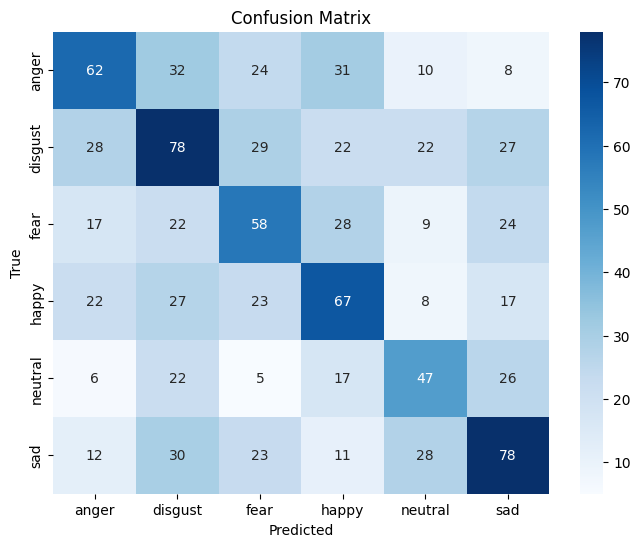

In [79]:

Real_labels,prdict_label,cm,report=evaluation(ann_model,test_ds,list(classes))




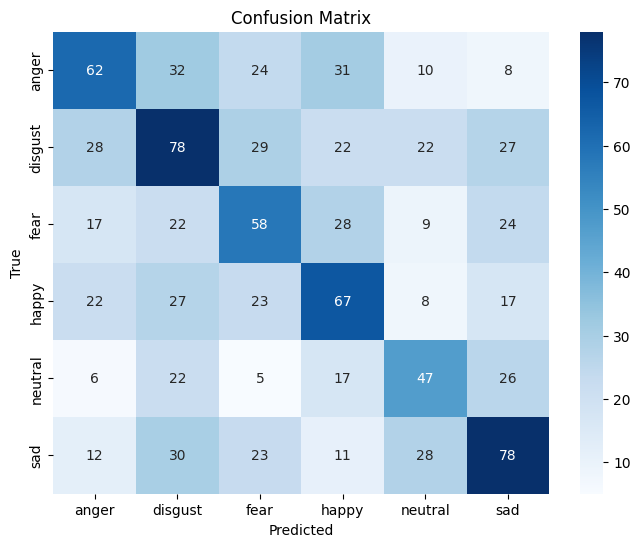

              precision    recall  f1-score   support

       anger       0.42      0.37      0.39       167
     disgust       0.37      0.38      0.37       206
        fear       0.36      0.37      0.36       158
       happy       0.38      0.41      0.39       164
     neutral       0.38      0.38      0.38       123
         sad       0.43      0.43      0.43       182

    accuracy                           0.39      1000
   macro avg       0.39      0.39      0.39      1000
weighted avg       0.39      0.39      0.39      1000



In [80]:

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(classes), yticklabels=list(classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(report)

### CNN model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

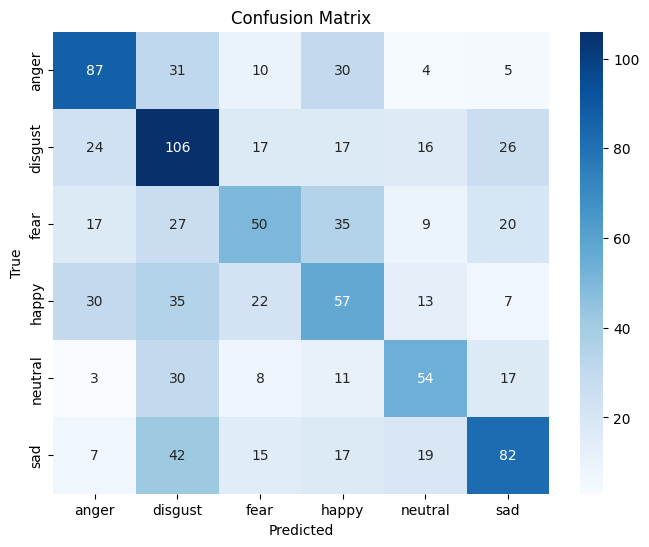

In [89]:

Real_labels2,prdict_label2,cm2,report2=evaluation(cnn_model,test_ds,list(classes))


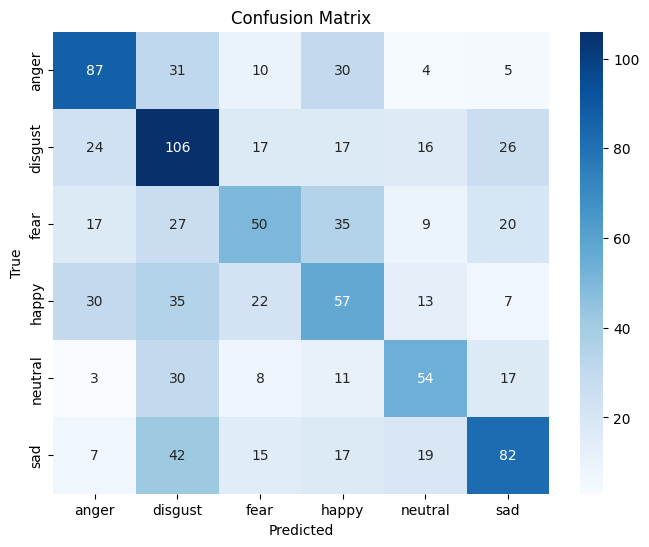

              precision    recall  f1-score   support

       anger       0.52      0.52      0.52       167
     disgust       0.39      0.51      0.44       206
        fear       0.41      0.32      0.36       158
       happy       0.34      0.35      0.34       164
     neutral       0.47      0.44      0.45       123
         sad       0.52      0.45      0.48       182

    accuracy                           0.44      1000
   macro avg       0.44      0.43      0.43      1000
weighted avg       0.44      0.44      0.44      1000



In [90]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=list(classes), yticklabels=list(classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(report2)

## inference

In [91]:
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    sound_sample,sr=librosa.load(filename ,sr=16000)
    return sound_sample

### Method 01

In [92]:

def infa_1(audio_path,model):
    testing_wav_data = load_wav_16k_mono(audio_path)
    
    scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
    results =model(embeddings)
    
    #print(results)
    
    my_classes=['anger', 'disgust', 'fear' ,'happy', 'neutral' ,'sad']

    
    class_scores = tf.reduce_mean(results, axis=0)
    top_class = tf.math.argmax(class_scores)
    inferred_class = my_classes[top_class]
    
    
    print(class_scores)
    print(top_class)
    print(inferred_class)


In [93]:
##ANN model
audio_path="/kaggle/input/audio-sentiment-analysis/Audio_Dataset/fear_emotion/1003_FEA.wav"
infa_1(audio_path,ann_model)

tf.Tensor(
[5.2941004e-06 4.6602581e-03 9.9356306e-01 1.7713312e-03 6.5063865e-09
 5.2971791e-09], shape=(6,), dtype=float32)
tf.Tensor(2, shape=(), dtype=int64)
fear


In [94]:

audio_path="/kaggle/input/audio-sentiment-analysis/Audio_Dataset/neutral_emotion/1008_NEU.wav"
infa_1(audio_path,ann_model)

tf.Tensor(
[1.9252336e-01 9.4614839e-03 4.3577492e-02 7.9023819e-03 7.4651384e-01
 2.1413829e-05], shape=(6,), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
neutral


In [96]:
##CNN model
audio_path="/kaggle/input/audio-sentiment-analysis/Audio_Dataset/fear_emotion/1003_FEA.wav"
infa_1(audio_path,cnn_model)

tf.Tensor(
[6.7055836e-02 9.9028282e-02 7.2976232e-01 1.0144929e-01 3.9357995e-04
 2.3106765e-03], shape=(6,), dtype=float32)
tf.Tensor(2, shape=(), dtype=int64)
fear


In [95]:

audio_path="/kaggle/input/audio-sentiment-analysis/Audio_Dataset/neutral_emotion/1008_NEU.wav"
infa_1(audio_path,cnn_model)

tf.Tensor([0.12467226 0.10750368 0.01547076 0.0736317  0.6648852  0.0138364 ], shape=(6,), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
neutral


### Method 2

In [97]:

def infa_2(audio_path,model_path):
    testing_wav_data = load_wav_16k_mono(audio_path)
    
    # Reload the model
    reloaded_model = tf.saved_model.load(model_path)
    
    # If it's a saved model, access the signature
    infer = reloaded_model.signatures['serving_default']
    
    # Now use the model for prediction, passing in the necessary inputs (e.g., audio data)
    # Make sure 'testing_wav_data' is prepared in the required shape/format
    input_tensor = tf.convert_to_tensor(testing_wav_data, dtype=tf.float32)
    
    # Get the prediction output
    output = infer(input_tensor)
    predictions = output['output_0']  # Adjust 'output_0' based on your model's output signature
    
    print(predictions)
    my_classes=['anger', 'disgust', 'fear' ,'happy', 'neutral' ,'sad']
    
    human_bot = my_classes[tf.math.argmax(predictions)]
    print(f'The main sound is: {human_bot}')

In [100]:
##Ann model
audio_path="/kaggle/input/audio-sentiment-analysis/Audio_Dataset/fear_emotion/1003_FEA.wav"
model_path="/kaggle/working/ann_voice_emotion"
infa_2(audio_path,model_path)

tf.Tensor(
[5.2941004e-06 4.6602581e-03 9.9356306e-01 1.7713312e-03 6.5063865e-09
 5.2971791e-09], shape=(6,), dtype=float32)
The main sound is: fear


In [102]:

audio_path="/kaggle/input/audio-sentiment-analysis/Audio_Dataset/neutral_emotion/1008_NEU.wav"
model_path="/kaggle/working/ann_voice_emotion"
infa_2(audio_path,model_path)

tf.Tensor(
[1.9252336e-01 9.4614839e-03 4.3577492e-02 7.9023819e-03 7.4651384e-01
 2.1413829e-05], shape=(6,), dtype=float32)
The main sound is: neutral


In [101]:
##Cnn model 
audio_path="/kaggle/input/audio-sentiment-analysis/Audio_Dataset/fear_emotion/1003_FEA.wav"
model_path="/kaggle/working/cnn_voice_emotion"
infa_2(audio_path,model_path)

tf.Tensor(
[6.7055836e-02 9.9028282e-02 7.2976232e-01 1.0144929e-01 3.9357995e-04
 2.3106765e-03], shape=(6,), dtype=float32)
The main sound is: fear


In [103]:

audio_path="/kaggle/input/audio-sentiment-analysis/Audio_Dataset/neutral_emotion/1008_NEU.wav"
model_path="/kaggle/working/cnn_voice_emotion"
infa_2(audio_path,model_path)

tf.Tensor([0.12467226 0.10750368 0.01547076 0.0736317  0.6648852  0.0138364 ], shape=(6,), dtype=float32)
The main sound is: neutral


## Zip the files

In [104]:


import zipfile
import os

def zip_folder(folder_path, zip_name):
    # Ensure the folder path exists
    if not os.path.exists(folder_path):
        print(f"Folder '{folder_path}' does not exist.")
        return
    
    # Create a ZipFile object
    with zipfile.ZipFile(zip_name, 'w') as zipf:
        # Iterate over all the files in the folder
        for root, _, files in os.walk(folder_path):
            for file in files:
                # Write each file into the ZIP file
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), folder_path))

    print(f"Folder '{folder_path}' zipped successfully as '{zip_name}'.")




In [106]:
# Example usage:
folder_to_zip = '/kaggle/working/cnn_voice_emotion'
zip_name = 'cnn_voice_emotion.zip'

zip_folder(folder_to_zip, zip_name)

Folder '/kaggle/working/cnn_voice_emotion' zipped successfully as 'cnn_voice_emotion.zip'.
